### Functions for attention

In [1]:
def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

In [2]:
import sys
sys.path.insert(1, '../')
from utils.dataset import EHRDatasetCodePrediction
from model.tokenizer import EHRTokenizer
import torch
from torch import nn
import matplotlib.pyplot as plt
import pytorch_pretrained_bert as Bert
from torch.utils.data import DataLoader
from model.model import *
import seaborn as sns
from utils.config import BertConfig
from model.model2 import *
from model.trainer import PatientTrajectoryPredictor
import pytorch_lightning as pl
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
tokenizer = EHRTokenizer(task='ccsr')

In [4]:
path = '../processing/readmission_data_ccsr_'
data = pd.read_parquet(path)

In [5]:
model_config = {
    'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
    'hidden_size': 300, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
    'gender_vocab_size': 3,
    'max_position_embeddings': 32, # maximum number of tokens
    'hidden_dropout_prob': 0.1, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 12, # number of attention heads
    'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
    'intermediate_size': 300, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
}

In [6]:
class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embeddings'),
            initializer_range=config.get('initializer_range'),
        )
        self.seg_vocab_size = config.get('seg_vocab_size')
        self.age_vocab_size = config.get('age_vocab_size')
        self.gender_vocab_size = config.get('gender_vocab_size')

In [7]:
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [134]:
def index_seq(tokens, symbol='[SEP]'):
    """
    Used to tell which sentence a specific token belongs to
    """
    flag = 0
    seg = []

    for token in tokens:
        if token == symbol:
            seg.append(flag)
            if flag == 0:
                flag = 1
            else:
                flag = 0
        else:
            seg.append(flag)
    return seg

In [165]:
def get_attention_scores(model,i,sentence):
    #tokenized=tokenizer.tokenize(text)
    indexed_tokens=tokenizer.convert_tokens_to_ids(sentence, 'code')
    
    segment_ids=index_seq(sentence) #[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.bert.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.bert.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(bert_config,outputs_query[0])
    key_layer = transpose_for_scores(bert_config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(bert_config.hidden_size / bert_config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs, sentence

### Visualize attention for Masked Language Modeling

In [166]:
bert_config = BertConfig(model_config)
model = BertForMaskedLM(bert_config) 
PATH = "../saved_models/MLM/deep_notsuffled"
model = load_model(PATH, model)

#model.bert.encoder.layer[0].attention.self

In [167]:
data['len'] = data['hadm_id'].apply(lambda x: len(x))

In [168]:
patient = data[data['len'] == 2]

In [169]:
inputsentence = patient['ccsr'].iloc[3][:].tolist()

In [170]:
inputsentence

[array(['MUS011', 'BLD009', 'CIR007'], dtype=object),
 array(['NEO015', 'CIR009', 'CIR013', 'INJ030', 'CIR034', 'GEN006',
        'FAC025', 'CIR017', 'DIG004', 'FAC025', 'DIG015', 'DIG014',
        'SYM011'], dtype=object)]

In [171]:
patientvisits = ['[CLS]']

In [172]:
for a in inputsentence:
    patientvisits.extend(a)
    patientvisits.append('[SEP]')

In [173]:
sheet_to_df_map = pd.read_excel('../processing/findccsrcodes.xlsx', sheet_name='CCSR_Categories')

In [174]:
codemeaning = []
for a in patientvisits:
    if a not in (['[SEP]', '[CLS]']):
        res = sheet_to_df_map[sheet_to_df_map['Searchable list of CCSR categories, v2022.1'] == a]['Unnamed: 1'].iloc[0]
        codemeaning.append(res)
    else:
        codemeaning.append(a)

In [175]:
x,tokens=get_attention_scores(model,0,patientvisits)

In [176]:
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)

19

In [177]:
import seaborn as sns

<AxesSubplot:>

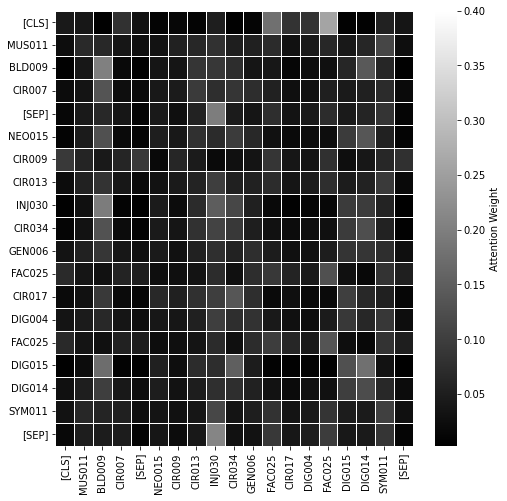

In [181]:
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(map1, annot=False, linewidths=1, fmt="f", ax=ax, xticklabels = patientvisits, yticklabels = patientvisits, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight'})

### Visualize attention for Readmission

<AxesSubplot:>

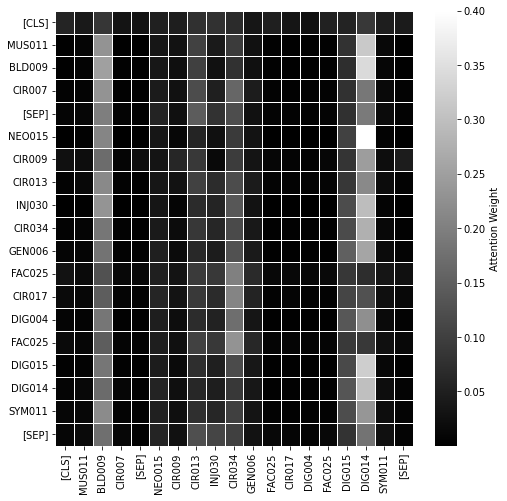

In [183]:
bert_config = BertConfig(model_config)
model = BertForMaskedLM(bert_config) 
PATH = "../saved_models/Readmission/deep_unshuffled"
model = load_model(PATH, model)

#inputsentence = data['ccsr'].iloc[0][0].tolist()
x,tokens=get_attention_scores(model,0,patientvisits)
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(map1, annot=False, linewidths=1, fmt="f", ax=ax, xticklabels = patientvisits, yticklabels = patientvisits, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight'})

### Visualize attention for Diagnose prediction

<AxesSubplot:>

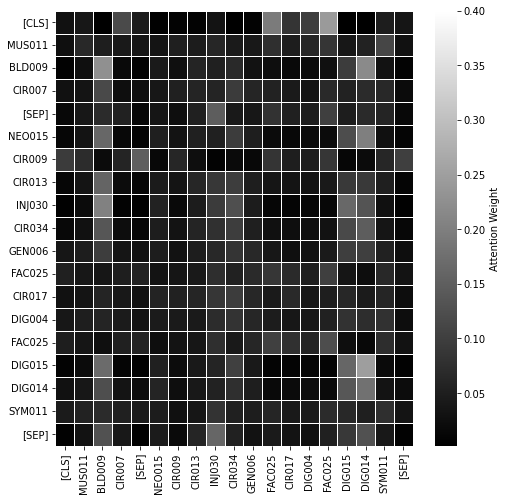

In [185]:
bert_config = BertConfig(model_config)
model = BertForMaskedLM(bert_config) 
PATH = "../saved_models/NextxVisit/deep_notsuffled"
model = load_model(PATH, model)
inputsentence = data['ccsr'].iloc[0][0].tolist()
x,tokens=get_attention_scores(model,0,patientvisits)
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(map1, annot=False, linewidths=1, fmt="f", ax=ax, xticklabels = tokens, yticklabels = tokens, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight'})


### Visualize attention for Medication Recommendation

In [129]:
bert_config = BertConfig(model_config)
model = BertForMaskedLM(bert_config) 
PATH = "../saved_models/nextvisit/medication/best_model"
model = load_model(PATH, model)

inputsentence = data['ccsr'].iloc[0][0].tolist()
x,tokens=get_attention_scores(model,0,inputsentence)
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(map1, annot=False, linewidths=1, fmt="f", ax=ax, xticklabels = tokens, yticklabels = tokens, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight'})

FileNotFoundError: [Errno 2] No such file or directory: '../saved_models/nextvisit/medication/best_model'